## Reinforcement Learning - TME 1 - Problèmes de Bandits

L'objectif du TME est d'implémenter les modèles UCB et LinUCB étudiés en cours.

Dans le rapport, certaines lignes de code sont omises pour alléger la présentation.

### 1 - Données

On commence par importer les données et trouver le meilleur bras.

In [1]:
import re
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# We begin by importing the data
lines = []
with open('CTR.txt', 'r') as file:
    for line in file:
        line = line.rstrip()
        lines.append([float(x) for x in re.split(':|;', line)][1:])
rewards = np.array(lines)
rewards = np.delete(rewards, range(5), 1)
context = np.array(lines)
context = np.delete(context, [0] + list(range(6, 16)), 1)

/home/pmarion/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  # Remove the CWD from sys.path while we load stuff.


In [3]:
T, nb_arms = rewards.shape
_, nb_context = context.shape

In [4]:
# Mean of rewards for each arm
np.mean(rewards, axis=0)

array([0.01645323, 0.07724607, 0.00735922, 0.26792701, 0.03255289,
       0.00230823, 0.09774602, 0.0355437 , 0.00616893, 0.24596128])

In [5]:
# Computation of the best arm and of the margin between best and second best (delta)
sorted_means = np.sort(np.mean(rewards, axis=0))
best_arm = np.argmax(np.mean(rewards, axis=0))
print('The best arm is arm : ' + str(best_arm))
delta = sorted_means[-1] - sorted_means[-2]
print('delta: ' + str(delta))

The best arm is arm : 3
delta: 0.02196572972113825


### 2 - Baselines, UCB, LinUCB

On commence par implémenter une fonction run, qui prend en paramètre la stratégie utilisée et qui exécute cette stratégie pour les T=5000 articles. Ensuite, cinq stratégies sont implémentées, dont les trois premières servent de benchmarks : 
+ stratégie Random : choix du bras au hasard
+ stratégie StaticBest : choix du bras avec la meilleur reward moyenne
+ stratégie optimale : choix du bras avec la meilleur reward instantanée (à chaque itération)
+ stratégie UCB
+ stratégie LinUCB

Les autres paramètres de run sont $\alpha$ (hyper-paramètre qui sert pour LinUCB) et verbose, un booléen qui définit la verbosité de la fonction.

Toutes les stratégies ont la même signature, sauf LinUCB qui prend en arguments supplémentaires le contexte et alpha.

In [6]:
def run(strat, alpha=1, verbose=True):
    average_rwds = np.zeros(nb_arms)
    nb_visits = np.zeros(nb_arms)
    all_rewards = np.zeros(T)
    good_answer = 0
    
    if strat == strat_lin_ucb:
        context_matrices, context_vectors = initialization_lin_ucb()
    
    for t in range(T):
        current_rwd = rewards[t]
        current_context = context[t]
        
        if strat == strat_lin_ucb:
            choix_annonceur, context_matrices, context_vectors = \
                strat(t, nb_visits, average_rwds, current_rwd, current_context, context_matrices, context_vectors, alpha)
        else:
            choix_annonceur = strat(t, nb_visits, average_rwds, current_rwd, current_context)
            
        reward_t = current_rwd[choix_annonceur]
        if reward_t == np.max(current_rwd):
            good_answer += 1

        average_rwds[choix_annonceur] = (nb_visits[choix_annonceur] * average_rwds[choix_annonceur] + reward_t) / (nb_visits[choix_annonceur]+1)
        all_rewards[t] = reward_t

        nb_visits[choix_annonceur] += 1
    
    if verbose:
        print('Number of optimal choices for ' + strat.__name__ + ' : ' + str(good_answer))
    return all_rewards

In [7]:
# baseline: random strategy
def strat_random(t, nb_visits, average_rwds, current_rwd, current_context):
    return np.random.randint(0, nb_arms)

In [8]:
# baseline: best mean arm if all history is known
def strat_static_best(t, nb_visits, average_rwds, current_rwd, current_context):
    return best_arm

In [9]:
# baseline: best current choice if all rewards are known
def strat_opt(t, nb_visits, average_rwds, current_rwd, current_context):
    return np.argmax(current_rwd)

In [10]:
def strat_ucb(t, nb_visits, average_rwds, current_rwd, current_context):
    # using current_rwd and current_context is not allowed in this strategy!
    
    # Implementation of Upper-Confidence Bound 
    # Peter Auer, Nicolo Cesa-Bianchi, and Paul Fischer. 2002. Finite-time Analysis of the
    # Multiarmed Bandit Problem. Mach. Learn. 47, 2-3 (May 2002), 235-256.
    
    # first visit unvisited states
    non_visited = np.where(nb_visits == 0)[0]
    if len(non_visited) > 0:
        return non_visited[0]

    # when all states are visited, choose the state whosen mean reward has the Upper-Confidence Bond (optimistic strategy)
    else:
        return np.argmax(average_rwds + np.sqrt(2 * np.log(t) / nb_visits))

In [11]:
def initialization_lin_ucb():
    # initialization of the context for Linear UCB strategy
    context_matrices = np.array([np.identity(nb_context) for i in range(nb_arms)])
    context_vectors = np.zeros((nb_arms, nb_context))
    return context_matrices, context_vectors

In [12]:
def strat_lin_ucb(t, nb_visits, average_rwds, current_rwd, current_context, context_matrices, context_vectors, alpha):
    # using current_rwd is not allowed before choosing the arm!
    
    # implementation of Linear Upper-Confidence Bound with disjoint linear models
    # Lihong Li, Wei Chu, John Langford, and Robert E. Schapire. 2010. A contextual-bandit
    # approach to personalized news article recommendation. In Proceedings of the 19th international conference
    # on World wide web (WWW ’10). ACM, New York, NY, USA, 661-670.
    
    inv_context_matrix = np.linalg.inv(context_matrices)
    theta = np.einsum('ijk,ik->ij', inv_context_matrix, context_vectors)
    p = theta.dot(current_context) + \
        alpha * np.sqrt(np.einsum('ijk,k->ij', inv_context_matrix, current_context).dot(current_context))
    chosen_arm = np.argmax(p)
    
    # update context matrices and context vectors
    context_matrices[chosen_arm] += np.outer(current_context, current_context)
    context_vectors[chosen_arm] += current_rwd[chosen_arm] * current_context
    
    return chosen_arm, context_matrices, context_vectors

### 3 - Expérimentations

On fait tourner les différentes stratégies. Pour LinUCB, on choisit deux valeurs de alpha: $\alpha=2$ et $\alpha=0.17$ (voir ci-dessous des éléments concernant le choix du paramètre $\alpha$).

On affiche le nombre de choix optimaux (sur 5000) pour les différentes stratégies. Comme attendu, la stratégie optimale est la meilleure, elle réalise uniquement des choix optimaux, tandis la stratégie aléatoire est mauvaise, elle réalise environ 10% de choix optimaux. 

In [13]:
rewards_random = run(strat_random)
rewards_static_best = run(strat_static_best)
rewards_opt = run(strat_opt)
rewards_ucb = run(strat_ucb)
rewards_lin_ucb_2 = run(strat_lin_ucb, 2)
rewards_lin_ucb_best = run(strat_lin_ucb, 0.17)

Number of optimal choices for strat_random : 498
Number of optimal choices for strat_static_best : 2681
Number of optimal choices for strat_opt : 5000
Number of optimal choices for strat_ucb : 1712
Number of optimal choices for strat_lin_ucb : 2455
Number of optimal choices for strat_lin_ucb : 3331


On affiche ensuite les rewards cumulés de toutes les stratégies. Comme attendu, Optimal est la meilleure stratégie et Random la moins bonne. StaticBest fait mieux que UCB, ce qui est normal puisqu'on s'attend à avoir un regret environ logarithmique pour UCB. En revanche, pour certaines valeurs du paramètre $\alpha$, LinUCB parvient à battre StaticBest (mais pas Optimal qui est un majorant absolu). 

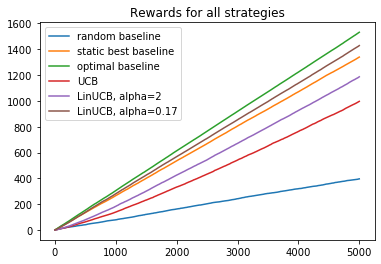

In [14]:
# Plotting the rewards of all strategies
plt.plot(range(T), np.cumsum(rewards_random), label='random baseline')
plt.plot(range(T), np.cumsum(rewards_static_best), label='static best baseline')
plt.plot(range(T), np.cumsum(rewards_opt), label='optimal baseline')
plt.plot(range(T), np.cumsum(rewards_ucb), label='UCB')
plt.plot(range(T), np.cumsum(rewards_lin_ucb_2), label='LinUCB, alpha=2')
plt.plot(range(T), np.cumsum(rewards_lin_ucb_best), label='LinUCB, alpha=0.17')
plt.title('Rewards for all strategies')
plt.legend(loc='best')
plt.show()

Le plot des regrets donne des résultats cohérents avec la figure précèdente. Le regret pour UCB croît de manière sous-linéaire, ce qui était attendu.

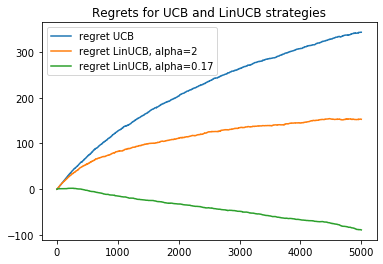

In [15]:
# Plotting the regrets of ucb and lin ucb strategies
regret_ucb = rewards_static_best - rewards_ucb
regret_lin_ucb_2 = rewards_static_best - rewards_lin_ucb_2
regret_lin_ucb_best = rewards_static_best - rewards_lin_ucb_best
plt.plot(range(T), np.cumsum(regret_ucb), label='regret UCB')
plt.plot(range(T), np.cumsum(regret_lin_ucb_2), label='regret LinUCB, alpha=2')
plt.plot(range(T), np.cumsum(regret_lin_ucb_best), label='regret LinUCB, alpha=0.17')
plt.legend(loc='best')
plt.title('Regrets for UCB and LinUCB strategies')
plt.show()

Enfin, on s'intéresse à la performance de LinUCB en fonction de la valeur de $\alpha$. La formule donnée par Li & al. (2010) est 

$$
\alpha = 1 + \sqrt{\frac{\log(2/\delta)}{2}}
$$

Théoriquement, on a donc $\alpha \geq 1$. On observe néanmoins qu'on obtient de meilleurs résultats en prenant $\alpha$ de l'ordre de 0.2. Cette remarque est aussi faite par les auteurs Li & al. (2010), qui écrivent: "Note the value of α (...) may be conservatively large in some applications, and so optimizing this parameter may result in higher total payoffs in practice."

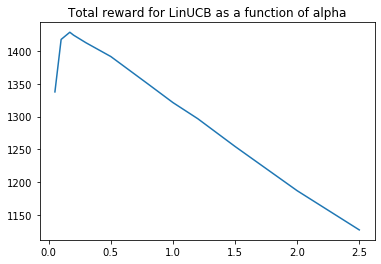

In [16]:
alphas = [0.05, 0.1, 0.17, 0.2, 0.3, 0.5, 0.8, 1, 1.2, 1.5, 2, 2.5]
res = []
for alpha in alphas:
    rewards_lin_ucb = run(strat_lin_ucb, alpha, verbose=False)
    res.append(np.sum(rewards_lin_ucb))
plt.plot(alphas, res)
plt.title('Total reward for LinUCB as a function of alpha')
plt.show()